# Analysis

**Run training scripts first:**
```bash
python train_resnet.py           # Task 1.1: Baseline
python train_broken.py           # Task 1.2: Broken skip connections
python train_transfer.py --mode random      # Task 1.4b
python train_transfer.py --mode full        # Task 1.4c
python train_transfer.py --mode lastblock   # Task 1.4c
```

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print(f"Using device: {device}")
os.makedirs("figures", exist_ok=True)

Using device: mps


---
## Task 1.1: Baseline Setup

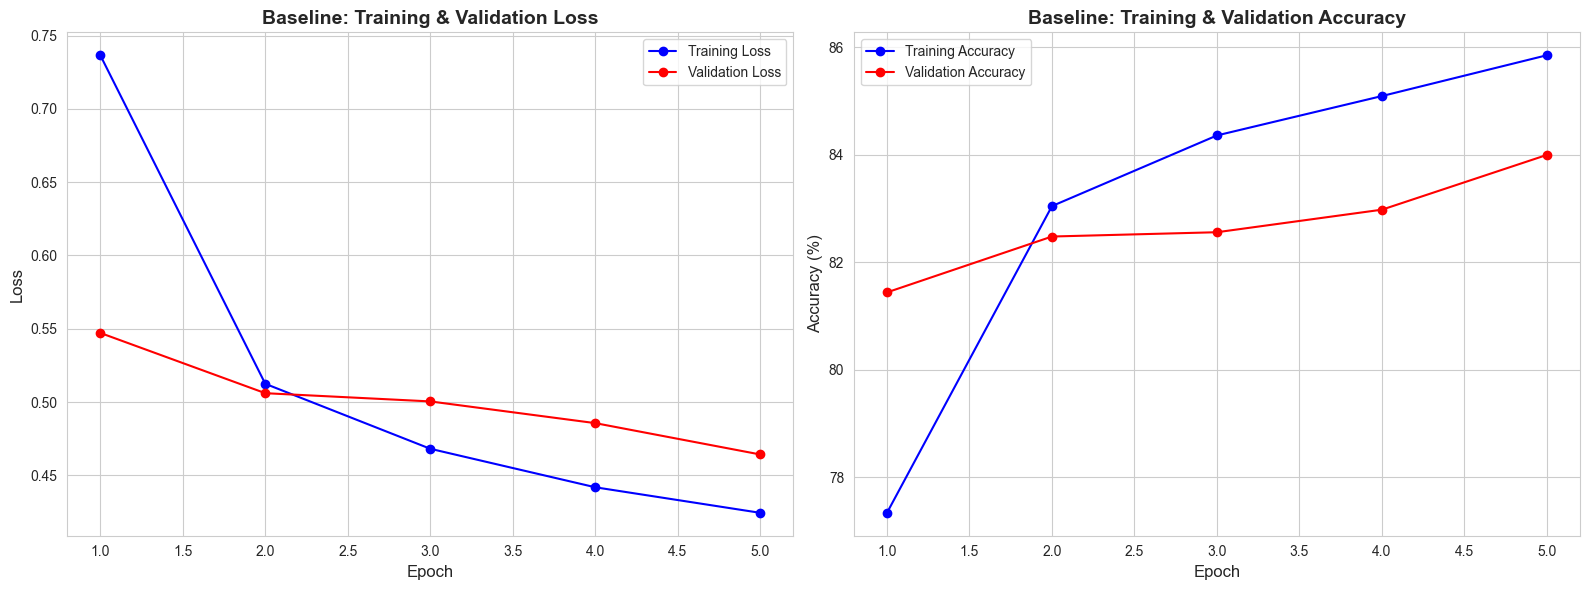

In [20]:
# Load baseline metrics
with open('results/baseline_metrics.json', 'r') as f:
    baseline = json.load(f)

epochs = range(1, len(baseline['train_loss']) + 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Loss
axes[0].plot(epochs, baseline['train_loss'], 'b-o', label='Training Loss')
axes[0].plot(epochs, baseline['val_loss'], 'r-o', label='Validation Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Baseline: Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True)

# Plot B: Accuracy
axes[1].plot(epochs, baseline['train_acc'], 'b-o', label='Training Accuracy')
axes[1].plot(epochs, baseline['val_acc'], 'r-o', label='Validation Accuracy')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Baseline: Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("figures/baseline_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

---
## Task 1.2: Residual Connections in Practice

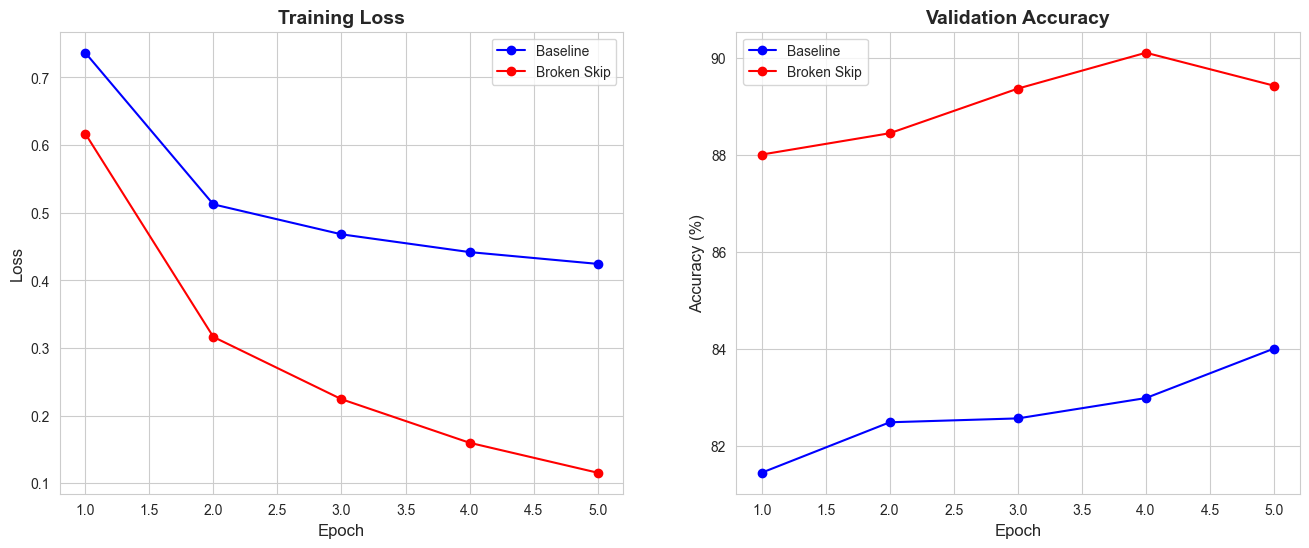

In [19]:
# Compare baseline vs broken skip connections
with open('results/broken_metrics.json', 'r') as f:
    broken = json.load(f)
with open('results/baseline_metrics.json', 'r') as f:
    baseline = json.load(f)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
epochs_base = range(1, len(baseline['train_loss']) + 1)
epochs_broken = range(1, len(broken['train_loss']) + 1)

# Plot A: Training Loss
axes[0].plot(epochs_base, baseline['train_loss'], 'b-o', label='Baseline')
axes[0].plot(epochs_broken, broken['train_loss'], 'r-o', label='Broken Skip')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True)

# Plot B: Validation Accuracy
axes[1].plot(epochs_base, baseline['val_acc'], 'b-o', label='Baseline')
axes[1].plot(epochs_broken, broken['val_acc'], 'r-o', label='Broken Skip')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True)

plt.savefig("figures/skip_connection_impact.png", dpi=300, bbox_inches="tight")
plt.show()

---
## Task 1.3: Feature Hierarchies and Representations

In [4]:
class FeatureExtractor:
    """
    Extracts features using forward hooks.
    Acts as a Context Manager to ensure hooks are always removed.
    """
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = {name: None for name in layer_names}
        self.hooks = []

    def _hook_fn(self, name):
        def hook(module, input, output):
            self.features[name] = nn.functional.adaptive_avg_pool2d(output, 1).flatten(1).detach()
        return hook

    def __enter__(self):
        # Register hooks when entering the 'with' block
        for name in self.layer_names:
            layer = dict(self.model.named_modules())[name]
            self.hooks.append(layer.register_forward_hook(self._hook_fn(name)))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        # Remove hooks when exiting
        for hook in self.hooks:
            hook.remove()
        print("Hooks removed.")

# Load model
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
model.fc = nn.Linear(2048, 10)

checkpoint_path = 'checkpoints/resnet_frozen.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
print(f"Loaded weights from {checkpoint_path}")

model = model.to(device)
model.eval()

preprocess = weights.transforms()
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

#Extract Features
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
num_samples = 1000

# Containers
all_features = {name: [] for name in layer_names}
all_labels = []
collected = 0

print(f"Extracting features from {num_samples} samples...")

with FeatureExtractor(model, layer_names) as extractor:
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            if collected >= num_samples:
                break
            
            inputs = inputs.to(device)
            _ = model(inputs) # Forward pass triggers hooks
            
            # Collect features from the dictionary populated by hooks
            for name in layer_names:
                all_features[name].append(extractor.features[name].cpu().numpy())
            
            all_labels.extend(labels.numpy())
            collected += len(labels)

# Concatenate results
for name in layer_names:
    all_features[name] = np.concatenate(all_features[name])[:num_samples]
all_labels = np.array(all_labels[:num_samples])

print(f"Feature extraction complete. Shapes: {[(k, v.shape) for k, v in all_features.items()]}")

Loaded weights from checkpoints/resnet_frozen.pth
Extracting features from 1000 samples...


 10%|█         | 16/157 [01:01<09:04,  3.86s/it]

Hooks removed.
Feature extraction complete. Shapes: [('layer1', (1000, 256)), ('layer2', (1000, 512)), ('layer3', (1000, 1024)), ('layer4', (1000, 2048))]


Computing t-SNE for layer1...
Computing t-SNE for layer2...
Computing t-SNE for layer3...
Computing t-SNE for layer4...


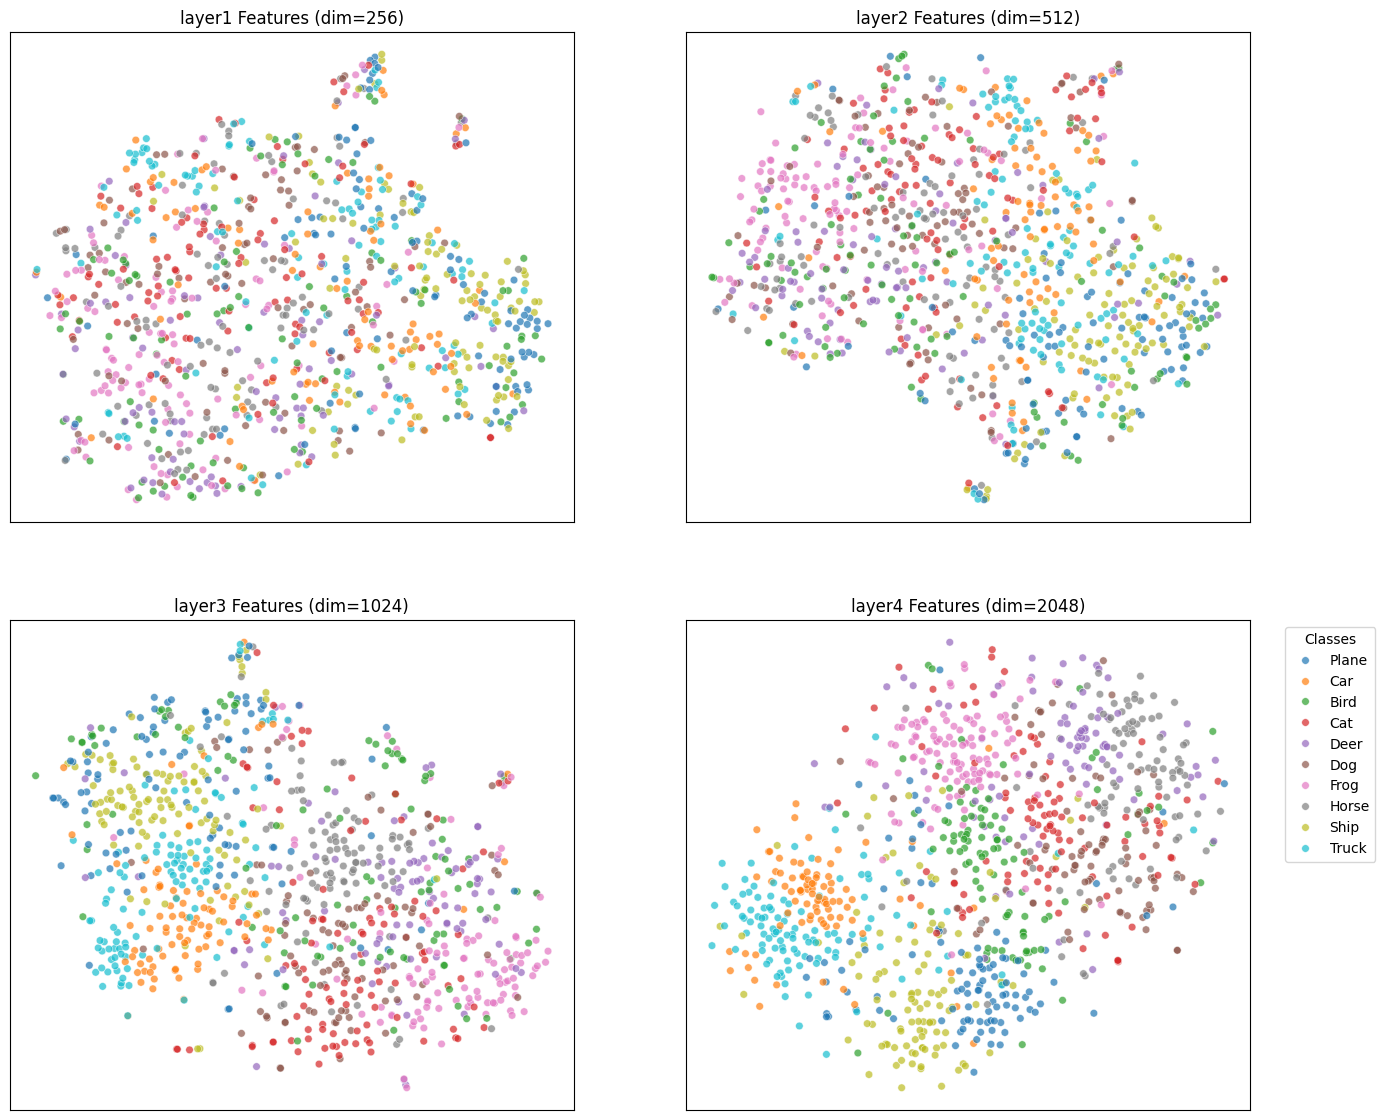

In [ ]:
palette = sns.color_palette("tab10", 10)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, name in enumerate(layer_names):
    print(f"Computing t-SNE for {name}...")
    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
    emb = tsne.fit_transform(all_features[name])
    
    sns.scatterplot(
        x=emb[:, 0], y=emb[:, 1],
        hue=all_labels, 
        palette=palette,
        legend='full' if idx == 3 else False,
        ax=axes[idx],
        s=30, alpha=0.7
    )
    
    axes[idx].set_title(f'{name} Features (dim={all_features[name].shape[1]})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

if axes[3].get_legend():
    handles, _ = axes[3].get_legend_handles_labels()
    axes[3].legend(handles, classes, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("figures/resnet152_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

### Analysis: Class Separability

**Early layers (layer1):** Mixed features, low-level patterns (edges, textures)

**Middle layers (layer2-3):** Emerging class structure, mid-level features

**Late layers (layer4):** Clear class separation, high-level semantic features

---
## Task 1.4: Transfer Learning and Generalization

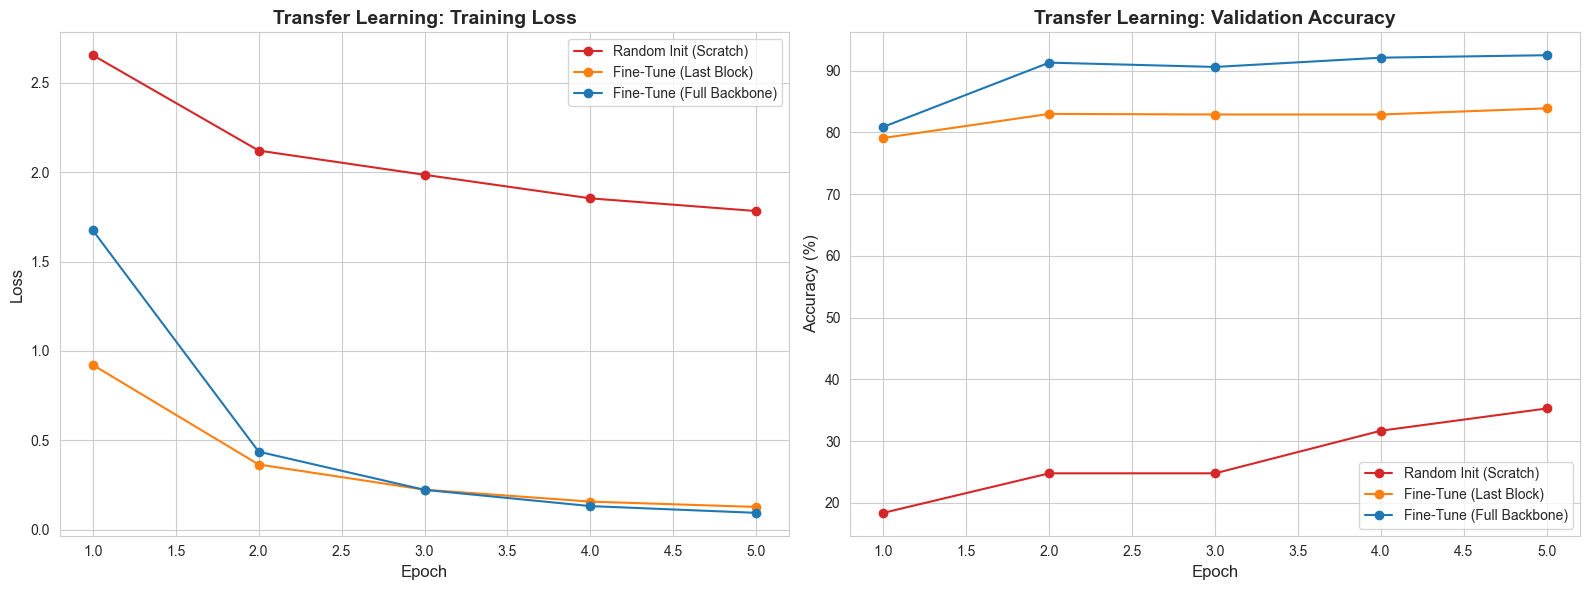

Final Performance Summary:

                           Val Accuracy  Train Loss
Mode                                               
Fine-Tune (Full Backbone)       92.5000      0.0955
Fine-Tune (Last Block)          83.9000      0.1284
Random Init (Scratch)           35.3000      1.7822


In [31]:
import json
import os
import matplotlib.pyplot as plt

# Configuration for the 3 modes
modes = [
    {'key': 'random',    'label': 'Random Init (Scratch)',     'color': 'tab:red'},
    {'key': 'lastblock', 'label': 'Fine-Tune (Last Block)',    'color': 'tab:orange'},
    {'key': 'full',      'label': 'Fine-Tune (Full Backbone)', 'color': 'tab:blue'}
]

# Load Data
results = {}
for m in modes:
    path = f"results/{m['key']}_metrics.json"
    if os.path.exists(path):
        with open(path, 'r') as f:
            results[m['key']] = json.load(f)
    else:
        print(f"Warning: {path} not found.")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for m in modes:
    key = m['key']
    if key not in results: continue
    
    data = results[key]
    epochs = range(1, len(data['train_loss']) + 1)
    
    # Plot A: Training Loss
    axes[0].plot(epochs, data['train_loss'], marker='o', linestyle='-', 
                 color=m['color'], label=m['label'])
    
    # Plot B: Validation Accuracy
    axes[1].plot(epochs, data['val_acc'], marker='o', linestyle='-', 
                 color=m['color'], label=m['label'])

# Styling
# Loss
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Transfer Learning: Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Transfer Learning: Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('figures/transfer_learning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print Summary Table
print("Final Performance Summary:\n")    
# Group by Mode and get the values from the last epoch
summary = df.groupby('Mode').last()[['Val Accuracy', 'Train Loss']]
summary = summary.sort_values('Val Accuracy', ascending=False)
print(summary.to_string(float_format="%.4f"))

---
## Task 1.5: Optional Experiments

/Users/abdulhafeez/miniconda3/envs/pa5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing t-SNE...
Computing UMAP...


/Users/abdulhafeez/miniconda3/envs/pa5/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


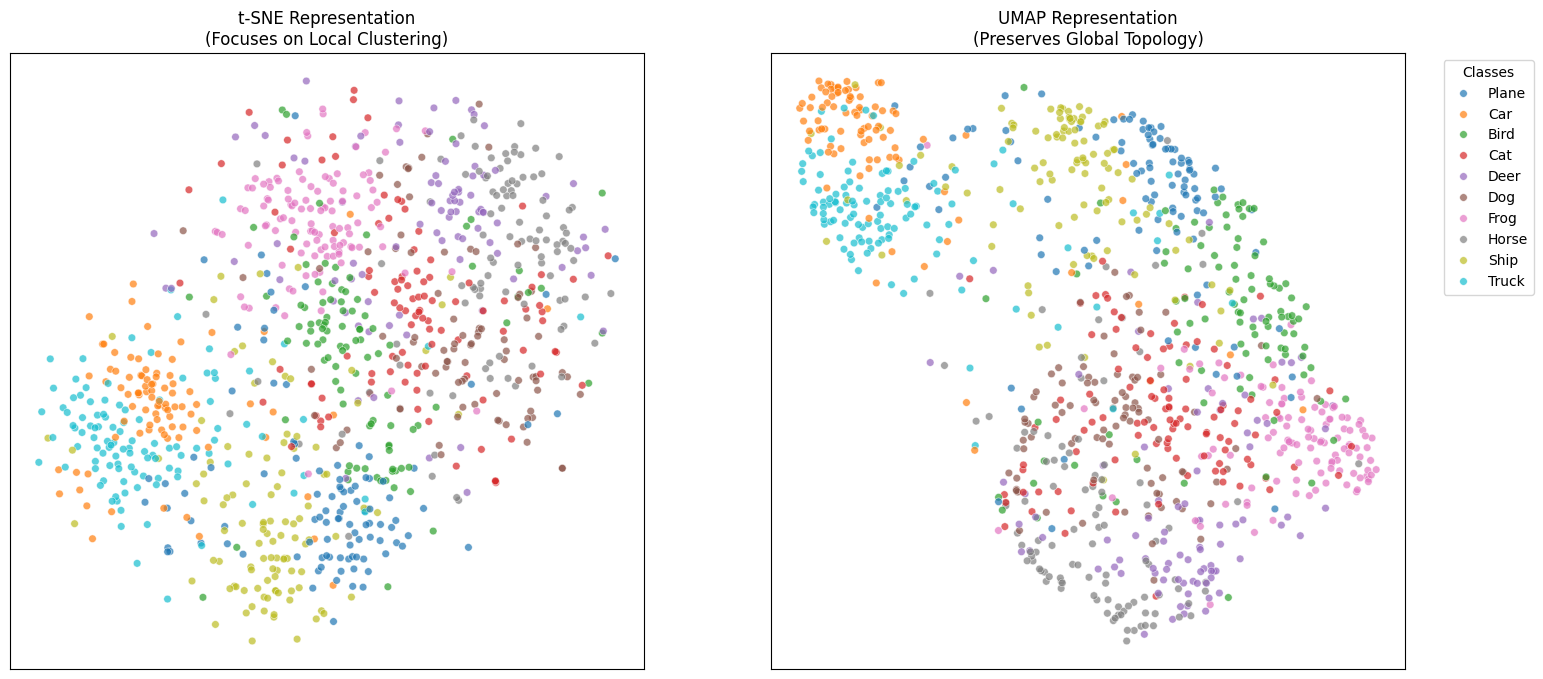

In [ ]:
# t-SNE vs UMAP comparison
try:
    import umap
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    palette = sns.color_palette("tab10", 10)
    
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
    tsne_emb = tsne.fit_transform(all_features['layer4'])

    sns.scatterplot(
        x=tsne_emb[:, 0], y=tsne_emb[:, 1],
        hue=all_labels, palette=palette,
        legend=False, ax=axes[0], s=30, alpha=0.7
    )
    axes[0].set_title('t-SNE Representation\n(Focuses on Local Clustering)')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    print("Computing UMAP...")
    umap_emb = umap.UMAP(n_components=2, random_state=42).fit_transform(all_features['layer4'])
    
    sns.scatterplot(
        x=umap_emb[:, 0], y=umap_emb[:, 1],
        hue=all_labels, palette=palette,
        legend='full', ax=axes[1], s=30, alpha=0.7
    )
    axes[1].set_title('UMAP Representation\n(Preserves Global Topology)')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    if axes[1].get_legend():
        handles, _ = axes[1].get_legend_handles_labels()
        axes[1].legend(handles, classes, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig("figures/tsne_vs_umap.png", dpi=300, bbox_inches="tight")
    plt.show()

except ImportError:
    print("UMAP not installed. Run: pip install umap-learn")

## Task 1.5 (b)

Generating predictions...


100%|██████████| 157/157 [08:30<00:00,  3.25s/it]


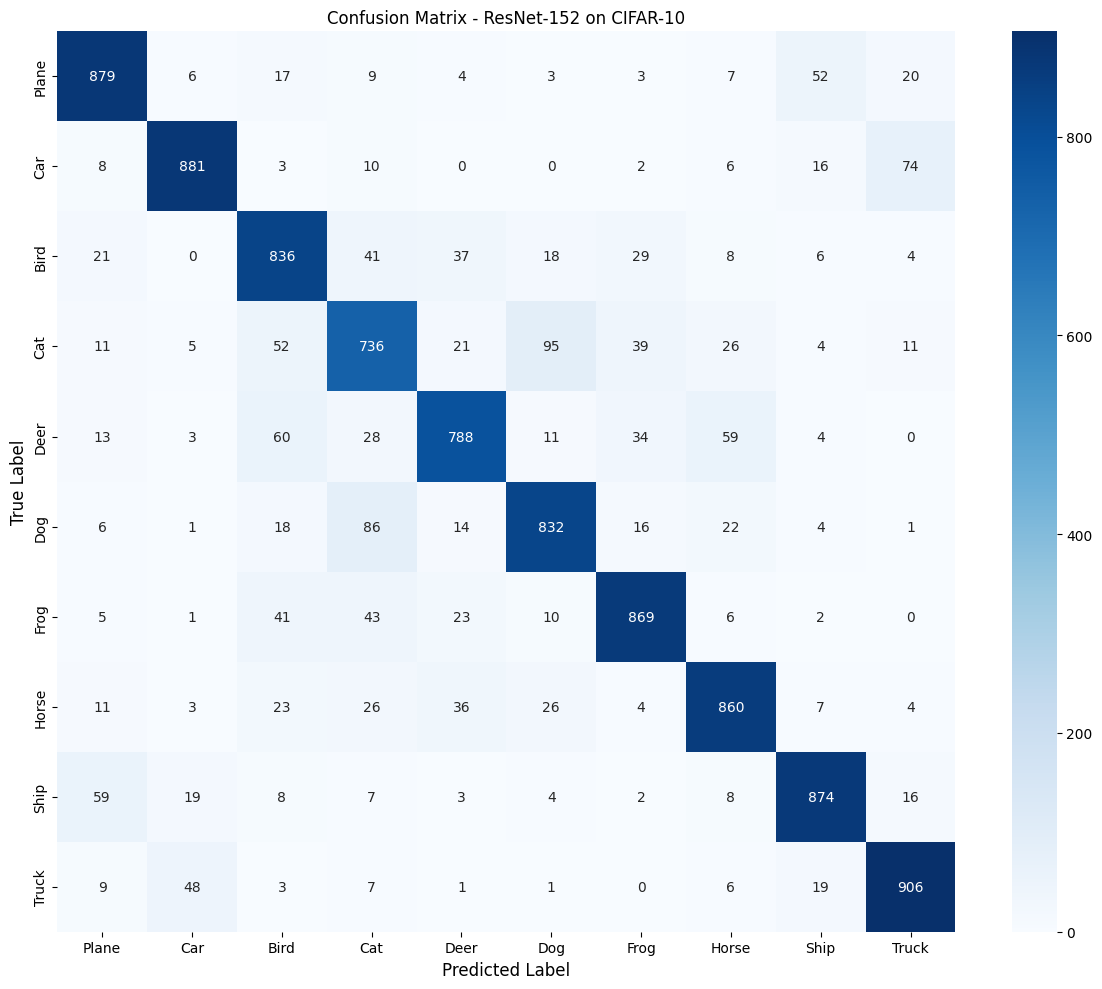


Most Confused Pairs:
  True: Cat         Predicted: Dog        -> 95 errors
  True: Dog         Predicted: Cat        -> 86 errors
  True: Car         Predicted: Truck      -> 74 errors
  True: Deer        Predicted: Bird       -> 60 errors
  True: Deer        Predicted: Horse      -> 59 errors


In [ ]:
# Confusion Matrix
model.eval()
model.to(device)

all_preds, all_true = [], []

print("Generating predictions...")
with torch.no_grad():
    from tqdm import tqdm
    for inputs, labels in tqdm(test_loader):
        outputs = model(inputs.to(device))
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.numpy())

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - ResNet-152 on CIFAR-10')
plt.tight_layout()
plt.savefig("figures/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)

print("\nMost Confused Pairs:")
for _ in range(5):
    i, j = np.unravel_index(cm_copy.argmax(), cm_copy.shape)
    count = cm_copy[i, j]
    
    if count == 0: break    
    print(f"  True: {classes[i]:<10}  Predicted: {classes[j]:<10} -> {count} errors")
    cm_copy[i, j] = 0

Loading ResNet-18 for comparison...
Extracting features from ResNet-18 (1000 samples)...


ResNet-18 Feature Extraction:  10%|█         | 16/157 [00:22<03:15,  1.39s/it]


Running t-SNE on ResNet-18 features...


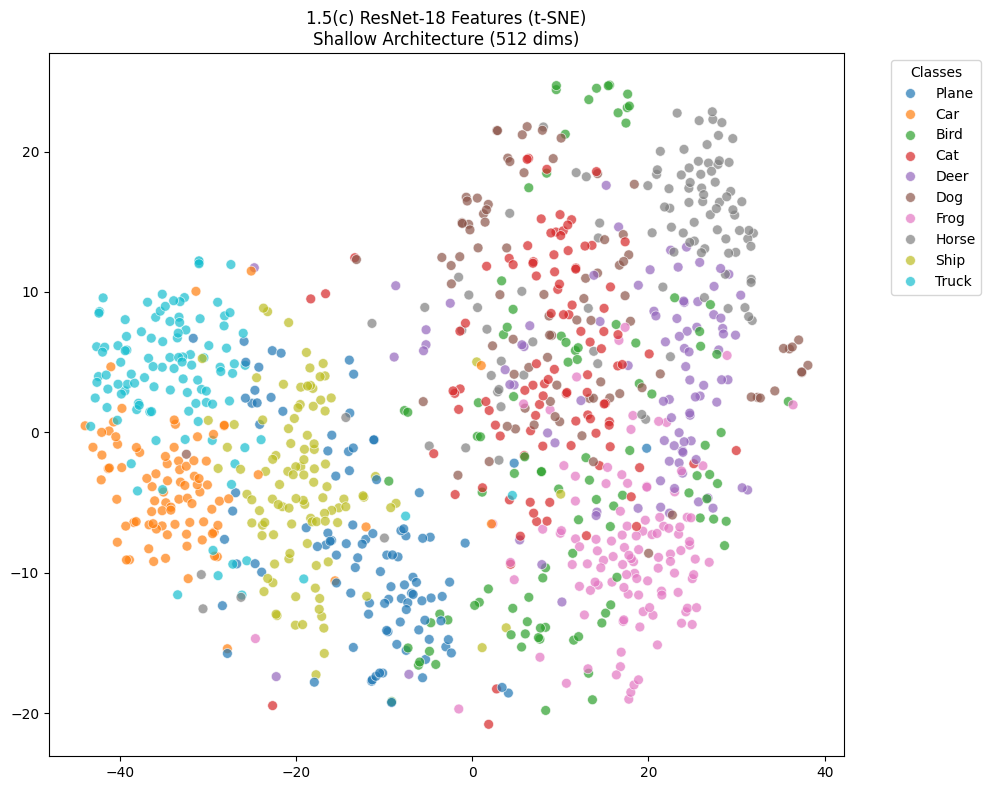

In [10]:
# --- Task 1.5(c): Feature Quality Comparison (ResNet-18 vs 152) ---

print("Loading ResNet-18 for comparison...")
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet18.eval()

# 1. Extract Features from ResNet-18 (Using same subset size as before)
# We limit to 1000 samples for t-SNE speed
num_samples = 1000
r18_features = []
r18_labels = []

def r18_hook(module, input, output):
    # Global Average Pooling inside the hook
    flat = nn.functional.adaptive_avg_pool2d(output, 1).flatten(1)
    r18_features.append(flat.detach().cpu().numpy())

# Attach hook to the final layer of ResNet-18
handle = resnet18.layer4.register_forward_hook(r18_hook)

print(f"Extracting features from ResNet-18 ({num_samples} samples)...")
collected = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="ResNet-18 Feature Extraction"):
        if collected >= num_samples: break
        inputs = inputs.to(device)
        _ = resnet18(inputs)
        r18_labels.extend(labels.numpy())
        collected += len(labels)

handle.remove()
r18_features = np.concatenate(r18_features)[:num_samples]
r18_labels = np.array(r18_labels)[:num_samples]

# 2. Run t-SNE on ResNet-18
print("Running t-SNE on ResNet-18 features...")
tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
r18_emb = tsne.fit_transform(r18_features)

# 3. Plot Comparison (ResNet-18 Only)
# Note: You can compare this plot to your previous ResNet-152 plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=r18_emb[:, 0], y=r18_emb[:, 1],
    hue=r18_labels, palette=sns.color_palette("tab10", 10),
    legend='full', s=50, alpha=0.7
)

# Fix Legend
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, classes, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f"1.5(c) ResNet-18 Features (t-SNE)\nShallow Architecture ({r18_features.shape[1]} dims)")
plt.tight_layout()
plt.show()

---
## Summary

1. **Baseline**: Frozen backbone achieves ~84% on CIFAR-10
2. **Skip connections**: Essential for gradient flow
3. **Feature hierarchies**: Increasing class separability in deeper layers
4. **Transfer learning**: Pretrained weights >> random; last block fine-tuning is optimal trade-off
5. **Optional**: Confusion analysis, t-SNE vs UMAP, ResNet depth comparison